# 08. recipes 패키지
https://recipes.tidymodels.org/index.html

https://www.tidymodels.org/learn/develop/recipes/

https://www.tidymodels.org/find/


# 

In [2]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

In [3]:
ames <- ames %>% mutate(Sale_Price = log10(Sale_Price))
set.seed(20221010)
ames_split <- initial_split(ames, prop = 0.8, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test <- testing(ames_split)

# 
# 
### recipes는 데이터 전처리를 위한 일련의 단계를 정의하는 객체

In [4]:
simple_ames <- 
    recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type,
           data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_dummy(all_nominal_predictors())
simple_ames

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Log transformation on Gr_Liv_Area
Dummy variables from all_nominal_predictors()

# 
# 
- 워크플로 생성

In [5]:
lm_model <-
    linear_reg() %>%
    set_engine("lm")

lm_wflow <-
    workflow() %>%
    add_model(lm_model)

# 
- 워크플로에 recipe 추가

In [6]:
lm_wflow <-
    lm_wflow %>%
    remove_variables() %>%
    add_recipe(simple_ames)
lm_wflow

Warning message:
"The workflow has no variables preprocessor to remove."


== Workflow ============================================================================================================
Preprocessor: Recipe
Model: linear_reg()

-- Preprocessor --------------------------------------------------------------------------------------------------------
2 Recipe Steps

* step_log()
* step_dummy()

-- Model ---------------------------------------------------------------------------------------------------------------
Linear Regression Model Specification (regression)

Computational engine: lm 


# 
- 데이터 적합

In [7]:
lm_fit <- fit(lm_wflow, ames_train)
predict(lm_fit, ames_test %>% slice(1:3))

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from a rank-deficient fit may be misleading"


.pred
<dbl>
5.372136
5.143401
4.976423


# 
- recipe 추출

In [8]:
lm_fit %>%
    extract_recipe()

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 2342 data points and no missing data.

Operations:

Log transformation on Gr_Liv_Area [trained]
Dummy variables from Neighborhood, Bldg_Type [trained]

# 
- 적합 결과 추출

In [9]:
lm_fit %>%
    extract_fit_parsnip() %>%
    tidy() %>%
    slice(1:5)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.776908797,0.2226460726,-3.489434,4.931170e-04
Gr_Liv_Area,0.629731505,0.0134567224,46.796797,0.000000e+00
Year_Built,0.002034791,0.0001126237,18.067168,2.374282e-68
Neighborhood_College_Creek,0.014776081,0.0078258498,1.888112,5.913623e-02
Neighborhood_Old_Town,-0.027737207,0.0080113634,-3.462233,5.454635e-04


# 
# 
# 
## recipe()

전처리
- 0 및 거의 0에 가까운 분산 변수는 제거해야 할 낮은 결과
- 특성이 단일 고유 값만 포함한다는 의미의 제로 분산 변수는 모델에 유용한 정보를 제공하지 않는다.

# 

#### Normalization
- ```step_center(var)``` - 평균을 빼서 중심 이동
- ```step_normalize(var)``` - 평균 빼고, 분산으로 나눠서 표준화

# 

#### Filters
- ```step_corr(threshold = 0.9)``` - 상관계수 절대값이 큰 변수 제거

- ```step_rm(var)``` - 변수 제거

- ```step_zv()``` - 분산이 0인 변수 제거

- ```step_nzv()``` - 분산이 거의 0인 변수 제거

# 

#### Transformations
- ```step_log(var, base = exp(1))``` - 로그 변환

- ```step_logit(var)``` - 로짓 변환

- ```step_poly(var, degree = 2)``` - 변수에 polynomial term 추가(glm에서 poly() 와 동일, 즉 orthogonal polynomial 이용)

- ```step_BoxCox()``` - Boxcox 변환

- ```step_YeoJohnson()``` - YeoJohnson 변환

# 

#### Discretization

- ```step_discretize(var, num_breaks = 4)``` - 연속형 변수 이산형으로 변환

- ```step_cut()``` - 연속형 변수를 지정한 값을 기준으로 이산형으로 변환
    -include_outside_range - 지정한 범위를 넘어선 값을 양끝 break에 포함시킬지 여부. default = FALSE이며 결측치 처리됨
    - breaks - 절단 기준이 되는 값

# 

#### Dummy variables and encodings
- ```step_string2factor()``` - 문자를 요인형으로

- ```step_date()``` - date 변수에서 year, month, day of week 변수를 새롭게 생성
    - feature = c(‘dow’, ‘month’, ‘year’) - 요일, 달, 연도 변수 추가
    - abbr = T - Sunday or Sun
    - label = Sunday or number

- ```step_holiday()``` - date 변수에서 공휴일에 관한 이진변수 새롭게 생성
    - holidays = c(‘LaborDay’, ‘NewYearDay’, ‘ChristmasDay’)
    - holidays = timeDate::listHolidays(‘US’)

- ```step_dummy()``` - character or factor 변수를 더미변수로 변환
    - one_hot = TRUE - C +1개의 더미변수 생성(one_hot = F: C-1개 더미변수 생성
- ```step_other()``` - 범주형 변수의 level이 여러개일 때, 하위 범주를 기타로 묶음
    - threshold = 0.05 - 하위 5% 범주는 기타로 묶임
    - other : 기타로 지정할 level 이름 지정

- ```step_interact(~ A:B)``` - 상호작용 항 추가

# 
# 
# 

### 상호작용
### ```step_interact(~ A:B)```

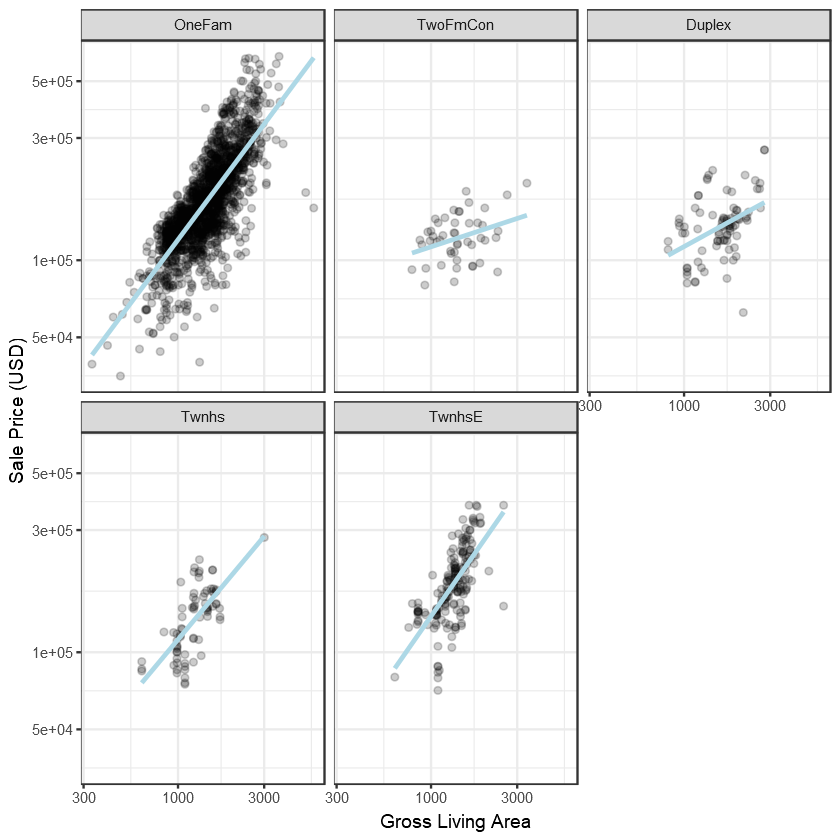

In [10]:
ggplot(ames_train, aes(x = Gr_Liv_Area, y = 10^Sale_Price)) + 
    geom_point(alpha = .2) + 
    facet_wrap(~ Bldg_Type) + 
    geom_smooth(method = lm, formula = y ~ x, se = FALSE, color = "lightblue") + 
    scale_x_log10() + 
    scale_y_log10() + 
    labs(x = "Gross Living Area", y = "Sale Price (USD)")

In [13]:
simple_ames <- 
    recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type,
           data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") )

In [14]:
simple_ames

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Log transformation on Gr_Liv_Area
Collapsing factor levels for Neighborhood
Dummy variables from all_nominal_predictors()
Interactions with Gr_Liv_Area:starts_with("Bldg_Type_")

# 
# 
# 
### 스플라인 함수
### ```step_ns(변수, deg_free)```

# 
- 스플라인은 모델이 유연한 비선형 관계를 에뮬레이트할 수 있도록 하는 열 집합으로 기존 수치 예측자를 대체합니다. 데이터에 더 많은 스플라인 항이 추가될수록 관계를 비선형적으로 표현하는 용량이 증가합니다. 불행히도 우연히 발생하는 데이터 추세를 포착할 가능성(즉, 과적합)을 증가시킬 수도 있습니다.

In [16]:
library(patchwork)
library(splines)

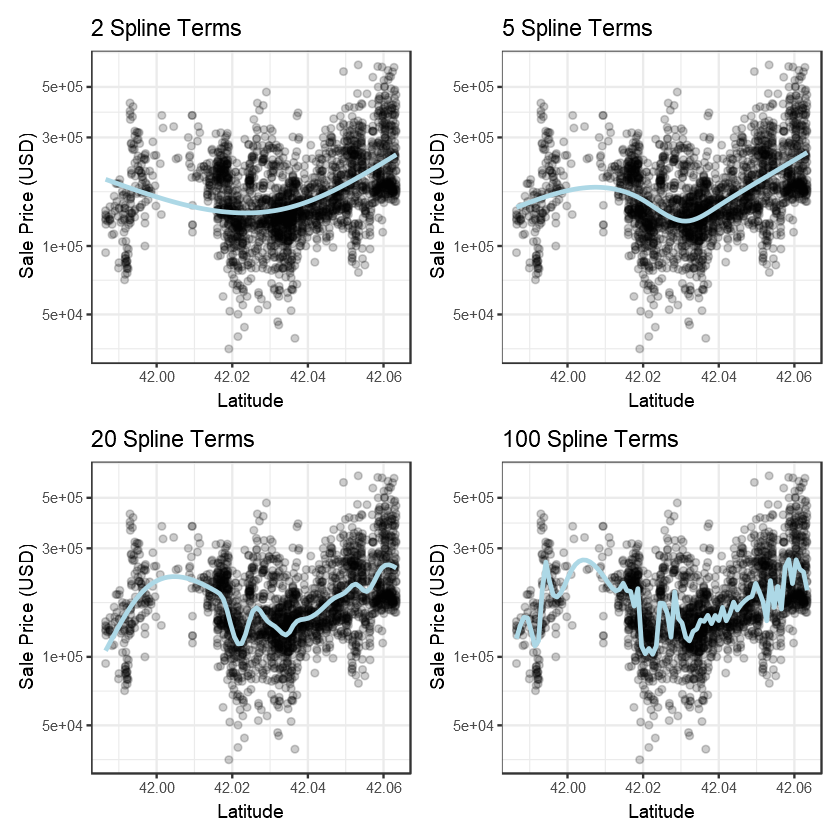

In [20]:
plot_smoother <- function(deg_free) {
    ggplot(ames_train, aes(Latitude, 10^Sale_Price)) + 
        geom_point(alpha = .2) + 
        scale_y_log10() +
        geom_smooth(
            method = lm,
            formula = y ~ ns(x, df = deg_free),
            color = "lightblue",
            se = FALSE
        ) + 
        labs(title = paste(deg_free, "Spline Terms"),
             y = "Sale Price (USD)")
}
(plot_smoother(2) + plot_smoother(5)) / (plot_smoother(20) + plot_smoother(100))

In [21]:
recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude,
       data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors()) %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
    step_ns(Latitude, deg_free = 20)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Log transformation on Gr_Liv_Area
Collapsing factor levels for Neighborhood
Dummy variables from all_nominal_predictors()
Interactions with Gr_Liv_Area:starts_with("Bldg_Type_")
Natural splines on Latitude

# 
# 
### 특징 추출
### ```step_pca()``` : 주성분 분석
### ```step_ica()``` : 독립 성분 분석
### ```step_nnmf()``` : 비음수 행렬 분해
### ```step_isomap()``` : 다차원 척도 분석
### ```step_umap()``` : 균일한 다양체 근사 및 투영

# 
# 
### 행 샘플링 
- 다운 샘플링 : 소수 클래스는 유지되고 다수 클래스의 무작위 샘플 추출
- 업 샘플링 : 소수 클래스의 샘플을 복제하여 클래스의 균형을 유지

In [23]:
library(themis)

# 
### ```step_sample()```

# 

### ```step_downsample()```
### ```step_upsample()```
### ```step_adasyn()```
### ```step_bsmote()```
### ```step_smote()```
### ```step_smotenc()```
### ```step_tomek()```

# 

### ```step_filter()```
### ```step_slice()``` 
### ```step_arrange()```
### ```step_naomit()```

# 
# 
### 일반 변환
### ```step_mutate()```

# 
# 
### 자연어 처리
https://textrecipes.tidymodels.org/index.html


In [33]:
library(textrecipes)
library(stopwords)

In [26]:
data("tate_text")

In [44]:
tate_text %>% head()
tate_text %>% dim

id,artist,title,medium,year
<dbl>,<fct>,<chr>,<fct>,<dbl>
21926,Absalon,Proposals for a Habitat,"Video, monitor or projection, colour and sound (stereo)",1990
20472,"Auerbach, Frank",Michael,Etching on paper,1990
20474,"Auerbach, Frank",Geoffrey,Etching on paper,1990
20473,"Auerbach, Frank",Jake,Etching on paper,1990
20513,"Auerbach, Frank",To the Studios,Oil paint on canvas,1990
21389,"Ayres, OBE Gillian",Phaethon,Oil paint on canvas,1990


[1] 4284    5

In [38]:
okc_rec <- recipe(~ medium + artist, data = tate_text) %>%
    step_tokenize(medium, artist) %>%
    step_stopwords(medium, artist) %>%
    step_tokenfilter(medium, artist, max_tokens = 10) %>%
    step_tfidf(medium, artist)

In [41]:
okc_obj <- okc_rec %>%
  prep()

In [43]:
bake(okc_obj, tate_text) %>% head()
bake(okc_obj, tate_text) %>% dim

tfidf_medium_colour,tfidf_medium_etching,tfidf_medium_gelatin,tfidf_medium_lithograph,tfidf_medium_paint,tfidf_medium_paper,tfidf_medium_photograph,tfidf_medium_print,tfidf_medium_screenprint,tfidf_medium_silver,tfidf_artist_akram,tfidf_artist_beuys,tfidf_artist_ferrari,tfidf_artist_john,tfidf_artist_joseph,tfidf_artist_león,tfidf_artist_richard,tfidf_artist_schütte,tfidf_artist_thomas,tfidf_artist_zaatari
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.314009,0.0000000,0,0,0.000000,0.0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.8601965,0,0,0.000000,0.4217902,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.8601965,0,0,0.000000,0.4217902,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.8601965,0,0,0.000000,0.4217902,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.0000000,0,0,2.353278,0.0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.000000,0.0000000,0,0,2.353278,0.0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 4284   20

# 
# 
# 

## Tidy a recipe
- 모든 ```step_*```에서 ```id```지정 가능
- ```id```를 설정하면, 동일한 recpipe의 step이 두 번 이상 사용되는 경우 식별 가능

In [47]:
ames_rec <-
    recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude,
           data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>%
    step_other(Neighborhood, threshold = 0.01, id = "my_id") %>%
    step_dummy(all_nominal_predictors()) %>%
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type")) %>%
    step_ns(Latitude, Longitude, deg_free = 20)

In [48]:
tidy(ames_rec)

number,operation,type,trained,skip,id
<int>,<chr>,<chr>,<lgl>,<lgl>,<chr>
1,step,log,FALSE,FALSE,log_VIj9S
2,step,other,FALSE,FALSE,my_id
3,step,dummy,FALSE,FALSE,dummy_poBjG
4,step,interact,FALSE,FALSE,interact_QiZ9f
5,step,ns,FALSE,FALSE,ns_qFh0F


In [49]:
lm_wflow <-
    workflow() %>%
    add_model(lm_model) %>%
    add_recipe(ames_rec)

In [50]:
lm_fit <- fit(lm_wflow, ames_train)

In [56]:
(estimated_recipe <-
    lm_fit %>%
    extract_recipe(estimated = TRUE))

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Training data contained 2342 data points and no missing data.

Operations:

Log transformation on Gr_Liv_Area [trained]
Collapsing factor levels for Neighborhood [trained]
Dummy variables from Neighborhood, Bldg_Type [trained]
Interactions with Gr_Liv_Area:(Bldg_Type_TwoFmCon + Bldg_Type_Duplex... [trained]
Natural splines on Latitude, Longitude [trained]

In [58]:
tidy(estimated_recipe, id = "my_id")

terms,retained,id
<chr>,<chr>,<chr>
Neighborhood,North_Ames,my_id
Neighborhood,College_Creek,my_id
Neighborhood,Old_Town,my_id
Neighborhood,Edwards,my_id
Neighborhood,Somerset,my_id
Neighborhood,Northridge_Heights,my_id
Neighborhood,Gilbert,my_id
Neighborhood,Sawyer,my_id
Neighborhood,Northwest_Ames,my_id


# 
# 
## 수동으로 역할 변경
### ```add_role()``` : 이미 레시피에서 역할이 있는 변수에 추가 역할을 추가
### ```remove_role()``` : 레시피에서 기존의 단일 역할을 제거
### ```update_role()``` : 레시피의 기존 역할을 변경하거나 아직 선언된 역할이 없는 변수에 초기 역할을 할당

In [84]:
data(biomass, package = "modeldata")

In [75]:
recipe(HHV ~ ., data = biomass) %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,predictor,original
dataset,nominal,predictor,original
carbon,numeric,predictor,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
HHV,numeric,outcome,original


#### sample더 이상 "predictor"(에 제공된 공식의 오른쪽에 있는 열에 대한 기본 역할 )로 취급되지 않으며 recipe()모델 피팅 또는 분석에 사용되지 않지만 데이터 세트에는 계속 유지됨

In [76]:
recipe(HHV ~ ., data = biomass) %>%
  update_role(sample, new_role = "id variable") %>%
  update_role(dataset, new_role = "splitting variable") %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,id variable,original
dataset,nominal,splitting variable,original
carbon,numeric,predictor,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
HHV,numeric,outcome,original


In [77]:
if (FALSE) {
recipe(HHV ~ ., data = biomass) %>%
  update_role(sample, new_role = NA_character_)
}

# 
# 


In [78]:
recipe(HHV ~ ., data = biomass) %>%
  add_role(carbon, sulfur, new_role = "something") %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,predictor,original
dataset,nominal,predictor,original
carbon,numeric,predictor,original
carbon,numeric,something,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
sulfur,numeric,something,original


In [79]:
recipe(HHV ~ ., data = biomass) %>%
  add_role(carbon, new_role = "something") %>%
  update_role(carbon, new_role = "something else", old_role = "something") %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,predictor,original
dataset,nominal,predictor,original
carbon,numeric,predictor,original
carbon,numeric,something else,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
HHV,numeric,outcome,original


In [80]:
if (FALSE) {
recipe(HHV ~ ., data = biomass) %>%
  add_role(carbon, sulfur, new_role = "something") %>%
  update_role(carbon, new_role = "something else")
}

# 
# 

In [81]:
recipe(HHV ~ ., data = biomass) %>%
  add_role(carbon, new_role = "something") %>%
  remove_role(carbon, old_role = "something") %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,predictor,original
dataset,nominal,predictor,original
carbon,numeric,predictor,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
HHV,numeric,outcome,original


In [82]:
recipe(HHV ~ ., data = biomass) %>%
  add_role(carbon, new_role = "something") %>%
  remove_role(carbon, old_role = "something") %>%
  remove_role(carbon, old_role = "predictor") %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,predictor,original
dataset,nominal,predictor,original
carbon,numeric,NA,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
HHV,numeric,outcome,original


In [83]:
recipe(biomass) %>%
  summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,NA,original
dataset,nominal,NA,original
carbon,numeric,NA,original
hydrogen,numeric,NA,original
oxygen,numeric,NA,original
nitrogen,numeric,NA,original
sulfur,numeric,NA,original
HHV,numeric,NA,original


# 
# 
# 

### ```update_role_requirements()``` : bake()에 해당 역할을 가진 열이 필요 없다고 알림

In [121]:
data(biomass, package = "modeldata")
biomass_train <- biomass[1:100,]
biomass_test <- biomass[101:200,]

In [122]:
rec <- recipe(HHV ~ ., data = biomass_train) %>%
  update_role(sample, new_role = "id variable") %>%
  update_role_requirements("id variable", bake = FALSE) %>%
  step_center(carbon)

rec %>% summary

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
sample,nominal,id variable,original
dataset,nominal,predictor,original
carbon,numeric,predictor,original
hydrogen,numeric,predictor,original
oxygen,numeric,predictor,original
nitrogen,numeric,predictor,original
sulfur,numeric,predictor,original
HHV,numeric,outcome,original


In [123]:
rec <- prep(rec, biomass_train)
bake(rec, biomass_test) %>% head()

sample,dataset,carbon,hydrogen,oxygen,nitrogen,sulfur,HHV
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Training,0.6585,6.21,44.60,0.43,0.19,19.069
NA,Training,-1.4915,6.21,46.68,0.52,0.17,19.361
NA,Training,-2.3915,6.25,46.55,1.49,0.19,17.734
NA,Training,-5.6015,5.17,51.77,0.42,0.33,14.310
NA,Training,-2.6115,6.10,48.80,0.23,0.17,17.485
NA,Training,-0.0915,6.24,43.46,2.21,0.27,18.757
